In [3]:
# Plot colors
lblue="#a6cee3"
blue = "#1f78b4"
lgreen = "#b2df8a"
green = "#33a02c"
black= "#424242"


from os import path, remove
import sys
import subprocess
from subprocess import call,check_output, DEVNULL
from pandas import read_csv
from os import path
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import MaxNLocator

def validate_args(datasetSize, distribution, parameter, searchAlgo, recordSizeBytes, nThreads):
    if recordSizeBytes not in [8,32,128]:
        print("The valid record size options are 8,32,128")
        exit()

# Adds a experiment to the tsv configuration file. Each experiment described the dataset 
# that is going to be searched and which search algorithm is going to be used.
# Input Args:
#             tsvpath: the path of the tsvfile
#             datasetSize: number of records of the dataset to be searched
#             distribution: distribution of the keys of the dataset to be searched
#             parameter:    datasets parameter
#             searchAlgo: name of the search algorithm to use
#             recordSizeBytes: size of record (key + payload)
#             nThreads: number of threads to be used for search
def add_to_tsv(tsvpath, datasetSize, distribution, parameter, searchAlgo, recordSizeBytes, nThreads):
    validate_args(datasetSize, distribution, parameter,searchAlgo, recordSizeBytes, nThreads)
    if not path.exists(tsvpath):
        with open(tsvpath, "w") as f:
            f.write("DatasetSize\tDistribution\tParameter\tSearchAlgorithm\tRecordSizeBytes\t#threads\n")
#     if parameter is "":
#         parameter = parameterMap[distribution]
#     distribution = paperToBenchmarkDistributionNames[distribution]
    with open(tsvpath, "a") as f:
        conf = str(datasetSize)+"\t"+ \
               str(distribution)+"\t"+ \
               str(parameter)+"\t"+ \
               str(searchAlgo)+"\t"+ \
               str(recordSizeBytes)+"\t"+ \
               str(nThreads)+"\n"
        f.write(conf)
    
def rm_tsv(tsvpath):
    if path.exists(tsvpath):
        remove(tsvpath)

def UaR_to_tsv(tsvpath, datasetSize, searchAlgo, recordSizeBytes, nThreads, parameter=42):
    add_to_tsv(tsvpath, datasetSize, "uniform", parameter, searchAlgo, recordSizeBytes, nThreads)
    
def fbids_to_tsv(tsvpath, searchAlgo, recordSizeBytes, nThreads):
    add_to_tsv(tsvpath, 1, "file", "src/datasets/fb/fb-289000.txt", searchAlgo, recordSizeBytes, nThreads)
    
def freq1_to_tsv(tsvpath, searchAlgo, recordSizeBytes, nThreads):
    add_to_tsv(tsvpath, 1, "file", "src/datasets/wf/wiki.txt", searchAlgo, recordSizeBytes, nThreads)
    
def freq2_to_tsv(tsvpath, searchAlgo, recordSizeBytes, nThreads):
    add_to_tsv(tsvpath, 1, "file", "src/datasets/wf/newman.txt", searchAlgo, recordSizeBytes, nThreads)

def fal_to_tsv(tsvpath, searchAlgo, recordSizeBytes, nThreads, parameter, datasetSize):
    add_to_tsv(tsvpath, datasetSize, "fal", parameter, searchAlgo, recordSizeBytes, nThreads)

def cfal_to_tsv(tsvpath, searchAlgo, recordSizeBytes, nThreads, parameter, datasetSize):
    add_to_tsv(tsvpath, datasetSize, "cfal", parameter, searchAlgo, recordSizeBytes, nThreads)

def gap_to_tsv(tsvpath, searchAlgo, recordSizeBytes, nThreads, random_seed, shape, datasetSize):
    add_to_tsv(tsvpath, datasetSize, "gap", str(random_seed)+","+str(shape), searchAlgo, recordSizeBytes, nThreads)
    

In [4]:
def run(tsvname):
    if not path.exists("../searchbench"):
        print("Please make sure searchbench is compiled. You can compile this by running make on the parent directory.")
        sys.exit()
        
    resultFile=tsvname+".out"
    if path.exists(resultFile):
        print("This tsv has been already executed and the results have been saved.")
        print("If you want to rerun the experiments please delete the file: "+tsvname+".out")
    else:
        with open(resultFile, "w") as log_file:
            subprocess.run(["python3","./getTimes.py","./replicate_experiments/"+tsvname], stdout=log_file, stderr=DEVNULL, cwd="../") 

In [5]:
import csv

def get_results(tsvname):
    times=[]
    with open(tsvname+".out", newline='') as csvfile:
        csvreader = csv.reader(csvfile, delimiter='\t')
        for row in csvreader:
            if len(row)>0 and row[0][0].isdigit():
                times.append(float(row[0].split()[7]))
    return times


#### Figure 2

This tsv has been already executed and the results have been saved.
If you want to rerun the experiments please delete the file: fig2.tsv.out


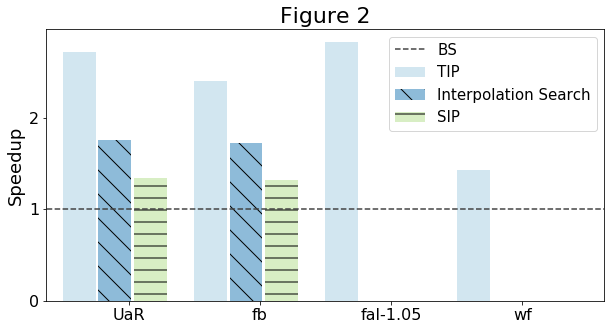

Caption: Speedup achieved by Interpolation Search methods over Binary Search on real datasets. The first two dataset UaR and fb_ids are uniformly distributed datasets, where as fal-1.05 and freq1 are skewed datasets. 8 Byte record are used.


In [20]:
tsv = "fig2.tsv"
rm_tsv(tsv)

# TODO(faster)
size=5 #8
for algorithm in ["bs", "sip", "is", "tip"]:
    UaR_to_tsv(tsv, 10**size, algorithm, 8, 1)
    
for algorithm in ["bs", "sip", "is", "tip"]:
    fbids_to_tsv(tsv, algorithm, 8, 1) 
    
for algorithm in ["bs", "tip"]:
    fal_to_tsv(tsv, algorithm, 8, 1, 1.05, 10**size) 

for algorithm in ["bs", "tip"]:
    freq1_to_tsv(tsv, algorithm, 8, 1)

run(tsv)
results=get_results(tsv)

uarResults=results[0:4]
fbidsResults=results[4:8]
falResults=results[8:10]
freq1Results=results[10:12]

# Calculate speedups of sip, is and tip compard to Binary Search
uarSpeedups = []
for i in range(1,len(uarResults)):
    uarSpeedups.append(uarResults[0]/uarResults[i])

fbidsSpeedups = []
for i in range(1,len(fbidsResults)):
    fbidsSpeedups.append(fbidsResults[0]/fbidsResults[i])

falSpeedups = []
for i in range(1,len(falResults)):
    falSpeedups.append(falResults[0]/falResults[i])
    
freq1Speedups = []
for i in range(1,len(freq1Results)):
    freq1Speedups.append(freq1Results[0]/freq1Results[i])

    
# Plot
# Group the speedups by algorithm
tipSpeedups=[uarSpeedups[0], fbidsSpeedups[0], falSpeedups[0], freq1Speedups[0]]
ISSpeedups=[uarSpeedups[1], fbidsSpeedups[1],0,0]
sipSpeedups=[uarSpeedups[2], fbidsSpeedups[2],0,0]

labels=["UaR", "fb", "fal-1.05", "wf"]
pos = [0,1,2,3]
width = 0.25 

fig, ax = plt.subplots(figsize=(10,5))
plt.bar(pos, 
        tipSpeedups, 
        width, 
        alpha=0.5, 
        color=lblue, 
        label="TIP") 

plt.bar([p + width+.02 for p in pos], 
        ISSpeedups,
        width, 
        alpha=0.5, 
        color=blue, 
        label="Interpolation Search",
        hatch="\\") 

plt.bar([p + width*2+.04 for p in pos], 
        sipSpeedups,
        width, 
        alpha=0.5, 
        color=lgreen, 
        label="SIP",
        hatch="-") 

plt.plot([-1,5],[1,1],linestyle="dashed", color=black, label="BS")

ax.set_ylabel('Speedup', size=18)

ax.set_title('Figure 2', size=22)

# Set the position of the x ticks
ax.set_xticks([p + 1.5 * width for p in pos])
ax.yaxis.set_major_locator(MaxNLocator(integer=True))

# Set the labels for the x ticks
ax.set_xticklabels(labels, size=15)
ax.tick_params(axis='both', which='major', labelsize=16)

# Setting the x-axis and y-axis limits
plt.xlim(min(pos)-width, max(pos)+width*4)
# plt.ylim([0, max(df['pre_score'] + df['mid_score'] + df['post_score'])] )

# Adding the legend and showing the plot
plt.legend(['TIP', 'Interpolation Search', 'SIP'], loc='upper right')
plt.legend(prop={'size': 15})
plt.show()

print("Caption: Speedup achieved by Interpolation Search methods over Binary Search on real datasets. The first two dataset UaR and fb_ids are uniformly distributed datasets, where as fal-1.05 and freq1 are skewed datasets. 8 Byte record are used.")

#### Figure 5

This tsv has been already executed and the results have been saved.
If you want to rerun the experiments please delete the file: fig5.tsv.out
[48.059952, 110.901353, 77.369208, 57.944734, 63.466083, 160.89782, 143.980346, 109.961972, 154.272664, 315.303737, 298.199862, 250.268893]


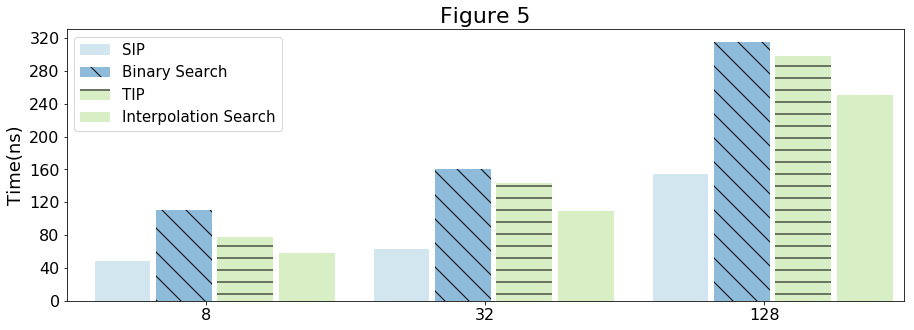

Caption: Comparison of SIP, TIP and Binary Search on the fb_ids dataset, over different record sizes.


In [35]:
# algos: i-hyp-64, i-opt-8, bs
# datasets: fb
# record-size: 8,32,128

tsv="fig5.tsv"
rm_tsv(tsv)

for recordSize in [8,32,128]:
    for algorithm in ["sip", "bs", "tip", "is"]:
        fbids_to_tsv(tsv, algorithm, recordSize, 1)

run(tsv)
results=get_results(tsv)

# Plot
# Group the results by algorithm
sipResult=[results[0], results[4], results[8]]
bsResult=[results[1], results[5], results[9]]
tipResult=[results[2], results[6], results[10]]
isResult=[results[3], results[7], results[11]]

pos = [0,1,2]
width = 0.20 

fig, ax = plt.subplots(figsize=(15,5))
plt.bar(pos, 
        sipResult, 
        width, 
        alpha=0.5, 
        color=lblue, 
        label="SIP") 

plt.bar([p + (width+.02)*1 for p in pos], 
        bsResult,
        width, 
        alpha=0.5, 
        color=blue, 
        label="Binary Search",
        hatch="\\") 

plt.bar([p + (width+.02)*2 for p in pos], 
        tipResult,
        width, 
        alpha=0.5, 
        color=lgreen, 
        label="TIP",
        hatch="-")

plt.bar([p + (width+.02)*3 for p in pos], 
        isResult,
        width, 
        alpha=0.5, 
        color=green, 
        label="Interpolation Search") 

ax.set_ylabel('Time(ns)', size=18)

ax.set_title('Figure 5', size=22)

# Set the position of the x ticks
ax.set_xticks([p + 1.5 * width for p in pos])
ax.yaxis.set_major_locator(MaxNLocator(integer=True))

# Set the labels for the x ticks
ax.set_xticklabels(["8","32","128"], size=15)
ax.tick_params(axis='both', which='major', labelsize=16)

# Setting the x-axis and y-axis limits
plt.xlim(min(pos)-width, max(pos)+width*4)
# plt.ylim([0, max(df['pre_score'] + df['mid_score'] + df['post_score'])] )

# Adding the legend and showing the plot
plt.legend(['SIP', 'Binary Search', 'TIP', 'Interpolation Search' ], loc='upper right')
plt.legend(prop={'size': 15})
plt.show()

print("Caption: Comparison of SIP, TIP and Binary Search on the fb_ids dataset, over different record sizes.")

#### Figure 6

This tsv has been already executed and the results have been saved.
If you want to rerun the experiments please delete the file: fig6.tsv.out
[[1.5760117854073739, 1.574247333357603, 1.47493155121147], [1.574247333357603, 1.47493155121147, 2.3183152201523307], [1.47493155121147, 2.3183152201523307, 2.2062112180956746]]


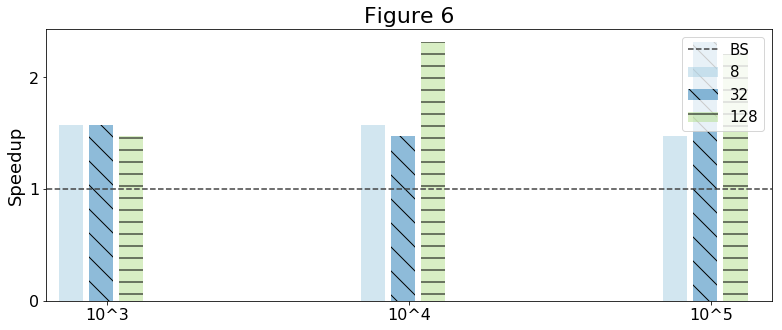

Caption: Speedup of SIP compared to Binary Search for different dataset and record sizes, on the UaR dataset. 10^9 records of size 128B exceed the memory capacity.


In [75]:
# algos: i-opt-8, bs
# datasets: UaR
# record-size: 8,32,128
    

tsv="fig6.tsv"
rm_tsv(tsv)

#TODO(faster)
datasetSizes=[3,4,5]#,6,7,8,9]
for algorithm in ["bs", "sip"]:
    for datasetSize in datasetSizes:
        for recordSize in [8,32,128]:
            UaR_to_tsv(tsv, 10**datasetSize, algorithm, recordSize, 1)   
            
run(tsv)
results=get_results(tsv)

# Group the results by algorithm
bsResults=results[0:(len(results)//2)]
sipResults=results[(len(results)//2):len(results)]

# Calculate speedup
sipSpeedup=[(bsResults[i]/sipResults[i]) for i in range(len(bsResults))]

# Plot
# Group the speedups by RecordSize
groupedByRecordSize = [[],[],[]]
for i in range(len(datasetSizes)):
    groupedByRecordSize[0].append(sipSpeedup[i])
    groupedByRecordSize[1].append(sipSpeedup[i+1])
    groupedByRecordSize[2].append(sipSpeedup[i+2])
print(groupedByRecordSize)

pos = [i for i in range(len(datasetSizes))]
width = 0.08

fig, ax = plt.subplots(figsize=(13,5))


plt.bar(pos, 
        groupedByRecordSize[0], 
        width, 
        alpha=0.5, 
        color=lblue, 
        label="8") 

plt.bar([p + (width+.02)*1 for p in pos], 
        groupedByRecordSize[1],
        width, 
        alpha=0.5, 
        color=blue, 
        label="32",
        hatch="\\") 

plt.bar([p + (width+.02)*2 for p in pos], 
        groupedByRecordSize[2],
        width, 
        alpha=0.5, 
        color=lgreen, 
        label="128",
        hatch="-")

plt.plot([-1,len(datasetSizes)],[1,1],linestyle="dashed", color=black, label="BS")

ax.set_ylabel('Speedup', size=18)

ax.set_title('Figure 6', size=22)

# Set the position of the x ticks
ax.set_xticks([p + 1.5 * width for p in pos])
ax.yaxis.set_major_locator(MaxNLocator(integer=True))

# Set the labels for the x ticks
xticks=["10^"+str(i) for i in datasetSizes]
ax.set_xticklabels(xticks, size=15)
ax.tick_params(axis='both', which='major', labelsize=16)

# Setting the x-axis and y-axis limits
plt.xlim(min(pos)-width, max(pos)+width*4)
# plt.ylim([0, max(df['pre_score'] + df['mid_score'] + df['post_score'])] )

# Adding the legend and showing the plot
plt.legend( loc='upper center', bbox_to_anchor=(0.5, 1.05))
plt.legend(prop={'size': 15})
plt.show()

print("Caption: Speedup of SIP compared to Binary Search for different dataset and record sizes, on the UaR dataset. 10^9 records of size 128B exceed the memory capacity.")


#### Figure 7

In [24]:
# algos: i-opt-8, bs
# datasets: UaR(10^3 - 10^9)
# record-size: 32
    
tsv="fig7.tsv"
rm_tsv(tsv)

#TODO(faster)
for datasetSize in [3,4,5]:#,6,7,8,9]:
    for algorithm in ["bs", "sip"]:
            UaR_to_tsv(tsv, 10**datasetSize, algorithm, 32, 1)  
    
run(tsv)
results=get_results(tsv)
print(results)

# X: Numver of records(log)
# Y: times

[37.937, 22.803, 63.8612, 26.6166, 99.33492, 35.47508]


#### Figure 8

In [25]:
tsv8="fig8_8.tsv"
tsv32="fig8_32.tsv"
tsv128="fig8_128.tsv"
rm_tsv(tsv8)
rm_tsv(tsv32)
rm_tsv(tsv128)

#TODO(add iseq)
for algorithm in ["sip", "iseq"]:
    for datasetSize in [3,4,5,6,7]:
        for gapShape in [0.7,0.9,0.99,0.99999]:
               gap_to_tsv(tsv8, algorithm, 8, 1, 47,gapShape, 10**datasetSize)
                
for algorithm in ["sip", "iseq"]:
    for datasetSize in [3,4,5,6,7]:
        for gapShape in [0.7,0.9,0.99,0.99999]:
               gap_to_tsv(tsv32, algorithm, 8, 1, 47,gapShape, 10**datasetSize)
                
for algorithm in ["sip", "iseq"]:
    for datasetSize in [3,4,5,6,7]:
        for gapShape in [0.7,0.9,0.99,0.99999]:
               gap_to_tsv(tsv128, algorithm, 8, 1, 47,gapShape, 10**datasetSize)
            
run(tsv)
results=get_results(tsv)
print(results)

# X: Numver of records
# Y: speedup sip vs iseq

This tsv has been already executed and the results have been saved.
If you want to rerun the experiments please delete the file: fig7.tsv.out
[37.937, 22.803, 63.8612, 26.6166, 99.33492, 35.47508]


#### Figure 9

In [26]:
tsv="fig9.tsv"
rm_tsv(tsv)

#TODO(faster)
for algorithm in ["bs", "tip"]:
    for datasetSize in [3,4,5]:#,6,7,8,9]:
        for shape in [0.5,1.05,1.25,1.5]:
            fal_to_tsv(tsv, algorithm, 8, 1, shape, 10**datasetSize)

for algorithm in ["bs", "tip"]:
    for datasetSize in [3,4,5]:#,6,7,8,9]:
        for shape in [0.5,1.05,1.25,1.5]:
            cfal_to_tsv(tsv, algorithm, 8, 1, shape, 10**datasetSize)

run(tsv)
results=get_results(tsv)
print(results)

# X: Numver of records
# Y: times

[32.782, 29.248, 25.668, 23.771, 49.9097, 50.4019, 49.0005, 48.8952, 78.02209, 78.13715, 76.32965, 77.48884, 30.244, 16.172, 24.747, 28.46, 38.7271, 16.6567, 30.5401, 31.1472, 52.32674, 30.17833, 40.57563, 48.99807, 32.258, 29.782, 23.524, 20.586, 50.2881, 49.594, 49.2459, 50.2249, 78.72139, 78.50125, 78.36136, 77.85273, 38.813, 34.895, 32.993, 30.077, 43.3809, 44.1489, 42.7334, 38.1973, 55.36159, 59.18234, 55.20911, 50.09433]


#### Figure 10

In [27]:
tsv="fig10.tsv"
rm_tsv(tsv)

#TODO(addiseq)
for algorithm in ["sip", "iseq"]:
    for datasetSize in [3,4,5]:
        for shape in [0.5,1.05,1.25,1.5]:
            fbids_to_tsv(tsv, algorithm, 8, 1)

run(tsv)
results=get_results(tsv)
print(results)

# X: Numver of records(log)
# Y: times

[37.844557, 38.034927, 37.076969, 37.866173, 37.44572, 37.618526, 37.452941, 37.341657, 37.060561, 37.368671, 38.096356, 39.502516]


#### Figure 11

In [28]:
tsv="fig11.tsv"
rm_tsv(tsv)

for algorithm in ["tip", "bs"]:
    for recordSize in [8,32,128]:
            freq1_to_tsv(tsv, algorithm, recordSize, 1)
            
for algorithm in ["tip", "bs"]:
    for recordSize in [8,32,128]:
            freq2_to_tsv(tsv, algorithm, recordSize, 1)
    

run(tsv)
results=get_results(tsv)
print(results)

# X: Numver of records(log)
# Y: times

[35.696086, 36.944104, 41.403593, 45.838584, 51.119901, 56.512681, 61.899464, 68.122536, 81.162991, 82.329721, 92.825197, 124.917253]


#### Figure 12

In [29]:
tsv="fig12.tsv"
rm_tsv(tsv)

#TODO(faster)
for datasetSize in [3,4,5]:#6,7,8]:
        UaR_to_tsv(tsv, 10**datasetSize, "sip", 8, 1,42)

run(tsv)
results=get_results(tsv)
print(results)

# X: Numver of records(log)
# Y: times

[23.181, 23.3761, 33.85908]


#### Figure 18

In [30]:
tsv="fig18.tsv"
rm_tsv(tsv)

#TODO(faster)
for algorithm in ["bs", "sip"]:
    for threads in [2,8,16,32]:
        UaR_to_tsv(tsv, 10**4, algorithm, 8, threads,42)
#         UaR_to_tsv(tsv, 10**8, "sip", 8, threads,42)

run(tsv)
results=get_results(tsv)
print(results)

# X: Numver of records(log)
# Y: times

[54.91195, 61.427125, 69.491394, 70.331322, 22.71505, 24.6945, 25.004212, 25.211584]
